In [201]:
import pandas as pd
import numpy as np
import datetime as dt


import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import joblib

import plotly.express as px
import plotly.graph_objs as go


%matplotlib inline

In [77]:
df = pd.read_csv('Data/cleaned_sales_data')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['revenue'] = df['Quantity'] * df['Price']

df

KeyboardInterrupt: 

In [78]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Invoice,1039562.0,537647.459037,26660.149945,489434.0,515339.00,537641.00,561036.00,581587.00
StockCode,1039562.0,33662.998902,23474.766215,10002.0,21791.00,22469.00,23307.00,90214.00
Quantity,1039562.0,11.201933,129.709885,1.0,1.00,3.00,11.00,80995.00
Price,1039562.0,3.330564,4.732068,0.0,1.25,2.10,4.13,1157.15
Customer ID,802693.0,15338.078239,1693.934876,12346.0,13988.00,15276.00,16809.00,18287.00
Revenue,1039562.0,19.343719,196.785914,0.0,3.90,9.95,17.70,168469.60
refund,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revenue,1039562.0,19.343719,196.785914,0.0,3.90,9.95,17.70,168469.60


In [164]:
daily_sales = df.groupby(pd.Grouper(key='InvoiceDate', freq='4D')).sum()
daily_sales.drop(columns = ['Invoice', 'StockCode', 'Customer ID'], axis = 1, inplace = True)
daily_sales.T

InvoiceDate,2009-12-01,2009-12-05,2009-12-09,2009-12-13,2009-12-17,2009-12-21,2009-12-25,2009-12-29,2010-01-02,2010-01-06,...,2011-11-01,2011-11-05,2011-11-09,2011-11-13,2011-11-17,2011-11-21,2011-11-25,2011-11-29,2011-12-03,2011-12-07
Quantity,130616.00,61427.00,63505.00,110075.00,39350.00,40509.00,0.0,0.0,22419.00,60937.00,...,114838.00,81144.00,104345.00,132449.00,75577.00,126109.00,72344.00,115243.00,86678.00,171577.00
Price,42881.61,26391.04,22687.39,42039.03,16793.56,14058.75,0.0,0.0,4742.08,6397.64,...,28089.74,29764.69,29691.72,42936.47,27931.94,43521.76,28027.97,43847.08,32730.40,29772.54
Revenue,227234.82,126105.22,121229.81,191887.67,82756.46,51725.85,0.0,0.0,32635.54,110090.18,...,198849.19,181674.26,186809.25,265301.85,142289.47,236043.67,122275.54,231334.25,159931.47,348723.27
refund,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
revenue,227234.82,126105.22,121229.81,191887.67,82756.46,51725.85,0.0,0.0,32635.54,110090.18,...,198849.19,181674.26,186809.25,265301.85,142289.47,236043.67,122275.54,231334.25,159931.47,348723.27


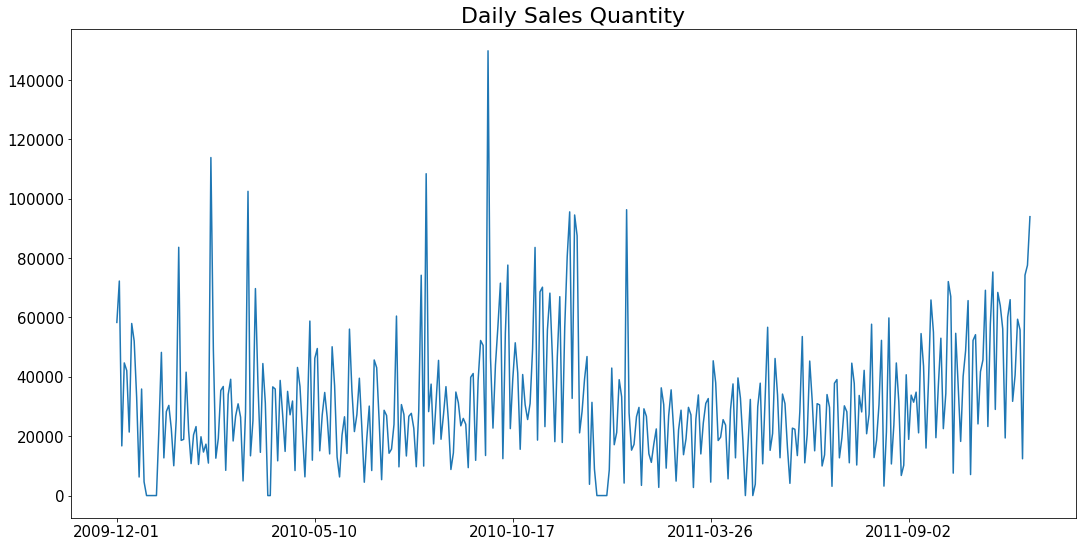

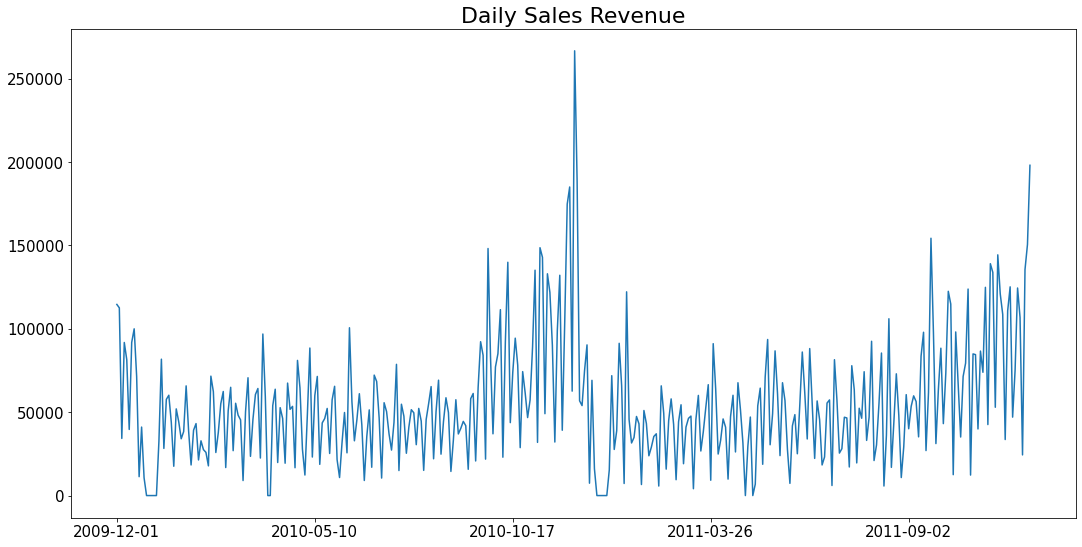

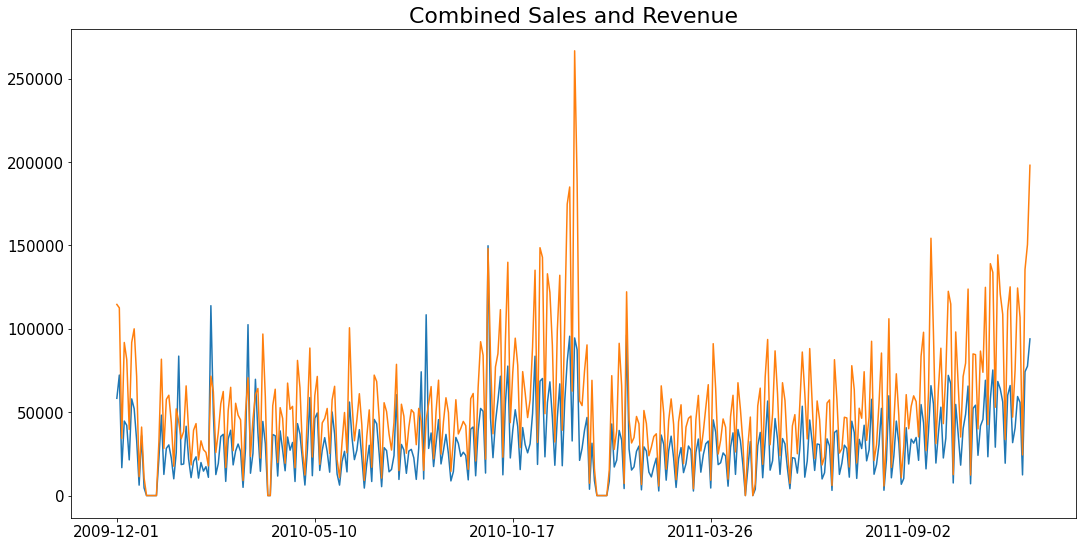

In [136]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    plt.figure(figsize=(18,9))
    for col in cols:
        plt.plot(df[col])
        
    plt.title(title, fontsize=22)
    plt.xlabel(xlab, fontsize=18)
    plt.ylabel(ylab, fontsize=1)
    plt.yticks(fontsize=15)
    plt.xticks(df.index[0::steps], fontsize=15);

plot_series(daily_sales,['Quantity'], title = 'Daily Sales Quantity', steps = 80)
plot_series(daily_sales,['revenue'], title = 'Daily Sales Revenue', steps = 80)
plot_series(daily_sales,['Quantity', 'revenue'], title = 'Combined Sales and Revenue', steps = 80)

We can see from the graph that there are days were no sales are made, espcially during the December/January holidays. Given that this is primarily a B2B business, it is unsurprising that customers are not placing orders during holidays. 

In [82]:
daily_sales.loc[daily_sales['Quantity'] == 0]


,Quantity,Price,Revenue,refund,revenue
InvoiceDate,,,,,
2010-01-03,0,0.0,0.0,0.0,0.0
2011-01-02,0,0.0,0.0,0.0,0.0


We can clearly see elements of seasonality in both the sales revenue and quanities sold. Beginning with back-to-school in September, until the new year, sales significantly increase. 

First step in determining stationarity beyond plotting the data is looking at the decomposition graphs for insight. 

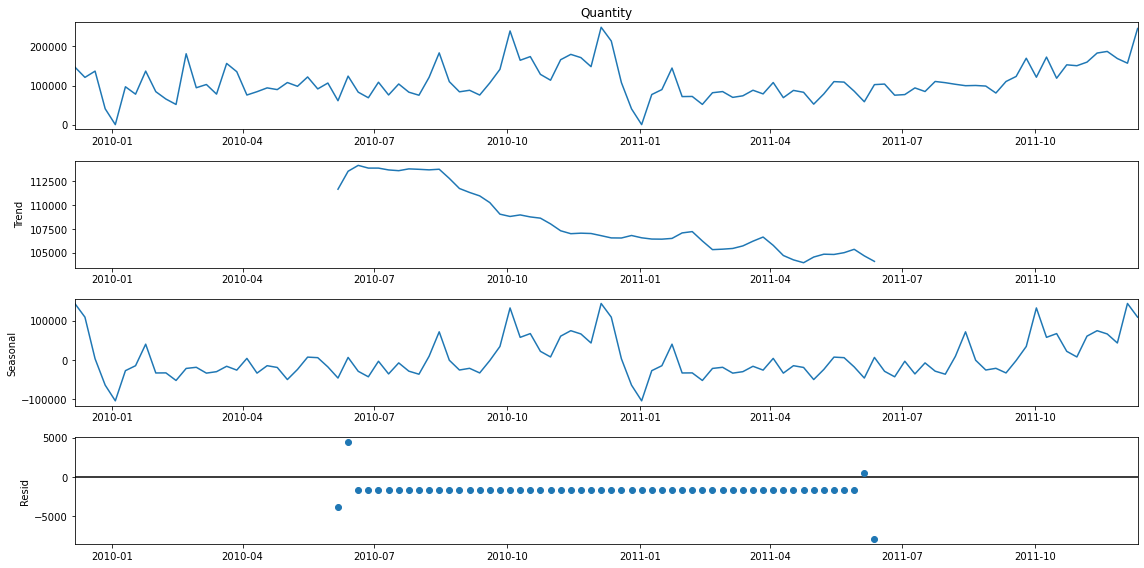

In [83]:
plt.rc("figure", figsize=(16,8))
decomp = seasonal_decompose(daily_sales['Quantity'])
decomp.plot();

There is no clear trend in the data, but obvious seasonality. There also appears to be significant noise in the data. 

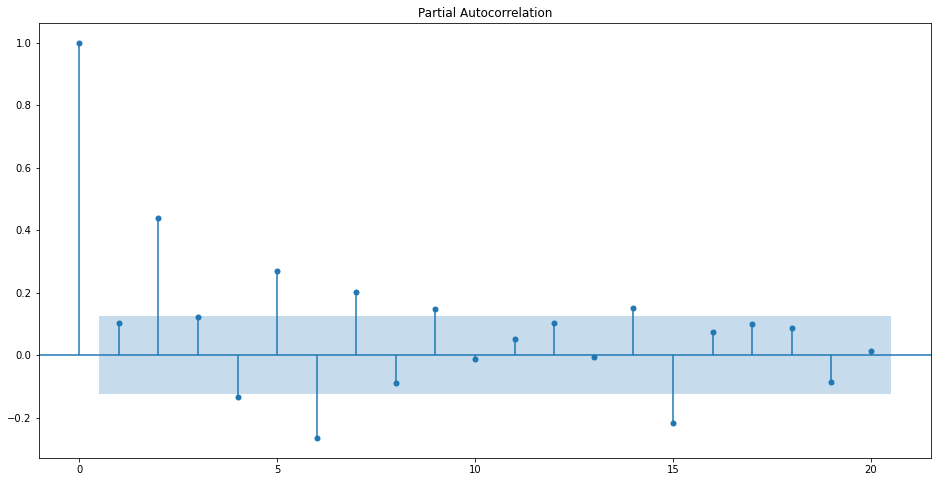

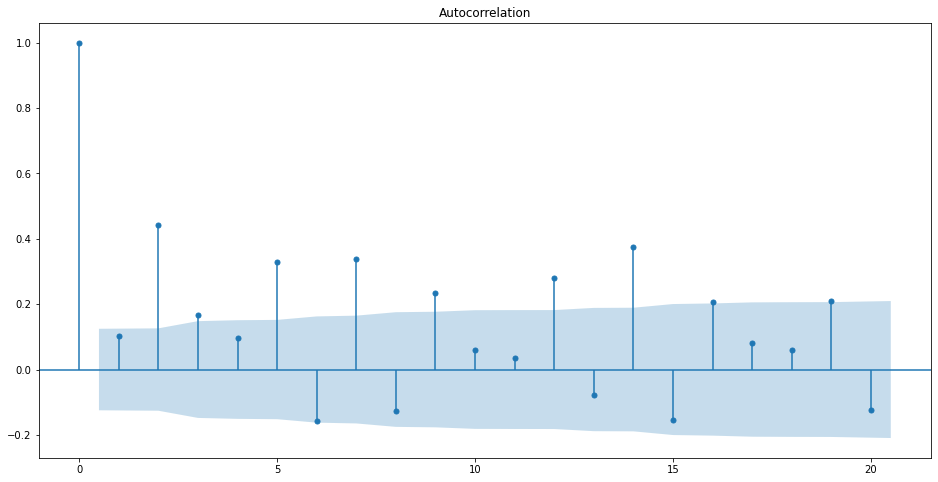

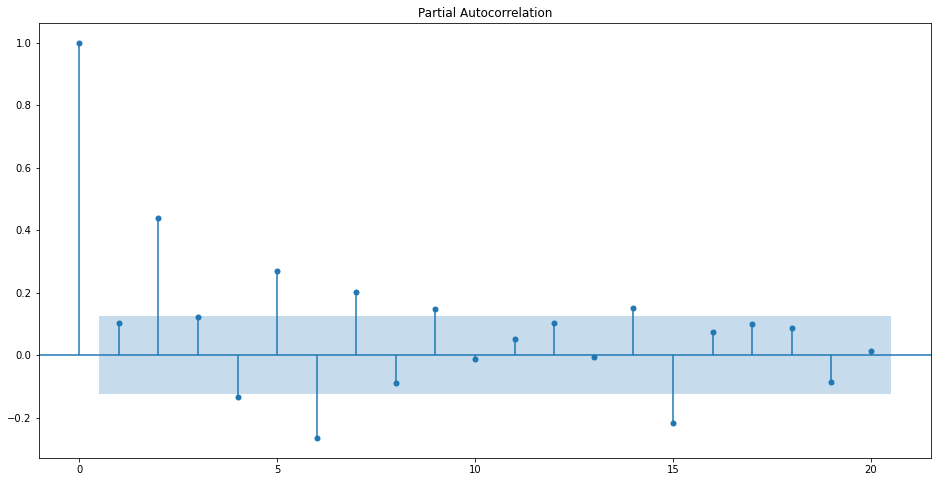

In [108]:
# The Autocorrelation plot also indicates that there is seasonality in the data. 
#We will want to use higher-order lags in our model.
#lt.rc("figure", figsize=(8,6))

plot_acf(daily_sales['Quantity'], lags = 20)
plot_pacf(daily_sales['Quantity'], lags = 20)


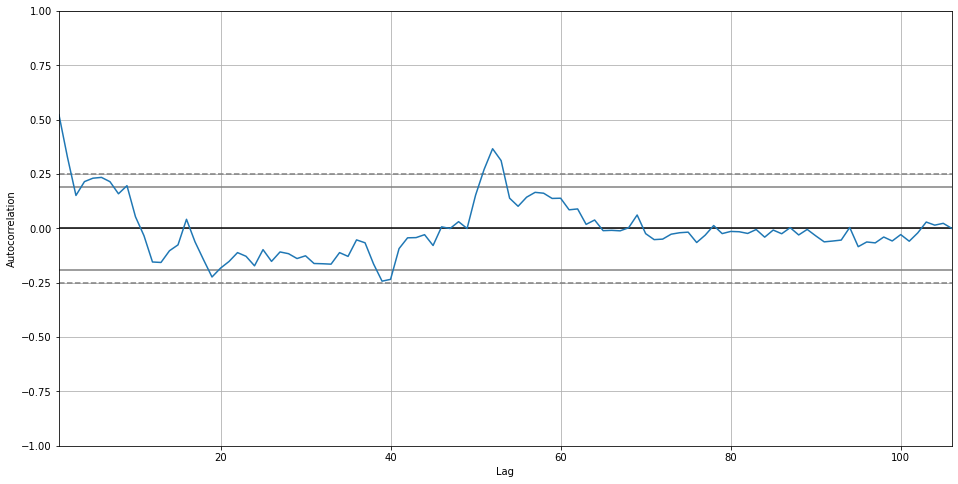

In [85]:
autocorrelation_plot(daily_sales['Quantity']); 

### Statistically Testing for Stationarity

In [137]:
def interpret_adfuller(feature):
    result = adfuller(feature)
    print('Augmented Dickey-Fuller Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


In [165]:
interpret_adfuller(daily_sales['Quantity'])

Augmented Dickey-Fuller Statistic: -1.277850
p-value: 0.639244
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


In [166]:
#The p value for qunatity is just under the 0.05 cut off for a 95% confidence interval.
interpret_adfuller(daily_sales['Quantity'].diff(1).dropna())

Augmented Dickey-Fuller Statistic: -6.038130
p-value: 0.000000
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


In [167]:
interpret_adfuller(daily_sales['revenue'])

Augmented Dickey-Fuller Statistic: -1.226260
p-value: 0.662199
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


In [168]:
interpret_adfuller(daily_sales['revenue'].diff().dropna())

Augmented Dickey-Fuller Statistic: -4.309367
p-value: 0.000428
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


In [169]:
#Adding the differential to the dataframe 
daily_sales['first_diff_quantity'] = daily_sales['Quantity'].diff(1)
daily_sales['first_diff_revenue'] = daily_sales['revenue'].diff(1)
daily_sales

,Quantity,Price,Revenue,refund,revenue,first_diff_quantity,first_diff_revenue
InvoiceDate,,,,,,,
2009-12-01,130616,42881.61,227234.82,0.0,227234.82,NaN,NaN
2009-12-05,61427,26391.04,126105.22,0.0,126105.22,-69189.0,-101129.60
2009-12-09,63505,22687.39,121229.81,0.0,121229.81,2078.0,-4875.41
2009-12-13,110075,42039.03,191887.67,0.0,191887.67,46570.0,70657.86
2009-12-17,39350,16793.56,82756.46,0.0,82756.46,-70725.0,-109131.21
2009-12-21,40509,14058.75,51725.85,0.0,51725.85,1159.0,-31030.61
2009-12-25,0,0.00,0.00,0.0,0.00,-40509.0,-51725.85
2009-12-29,0,0.00,0.00,0.0,0.00,0.0,0.00
2010-01-02,22419,4742.08,32635.54,0.0,32635.54,22419.0,32635.54


In [178]:
model_data = daily_sales[['first_diff_revenue', 'first_diff_quantity']]
model_data.dropna(inplace = True)
train, test = train_test_split(model_data, test_size = 0.085, shuffle = False)

<ipython-input-178-8177b3721081>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.dropna(inplace = True)


In [218]:
test

,first_diff_revenue,first_diff_quantity
InvoiceDate,,
2011-10-08,-126742.49,-76940.0
2011-10-12,-8808.38,-7030.0
2011-10-16,49037.52,33759.0
2011-10-20,-14736.14,-16197.0
2011-10-24,33347.50,33721.0
2011-10-28,-42877.38,-40588.0
2011-11-01,72221.36,48949.0
2011-11-05,-17174.93,-33694.0
2011-11-09,5134.99,23201.0


In [196]:
daily_sales.iloc[2011-10-8 :2011-12-7]

,Quantity,Price,Revenue,refund,revenue,first_diff_quantity,first_diff_revenue
InvoiceDate,,,,,,,


In [184]:
model = VAR(train)
ts_model = model.fit(maxlags=13, ic = 'aic' )
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Mar, 2021
Time:                     11:20:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    41.1700
Nobs:                     162.000    HQIC:                   40.8757
Log likelihood:          -3728.37    FPE:                4.62373e+17
AIC:                      40.6745    Det(Omega_mle):     3.96229e+17
--------------------------------------------------------------------
Results for equation first_diff_revenue
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                       1497.817769      3254.447238            0.460           0.645
L1.first_diff_revenue         -0.391513         0.144793           -2.704           0.007
L1.first_di

In [187]:
joblib.dump(ts_model, "VAR-time-series-model-4D-interval")


['VAR-time-series-model-4D-interval']

In [116]:
ts_model.k_ar

8

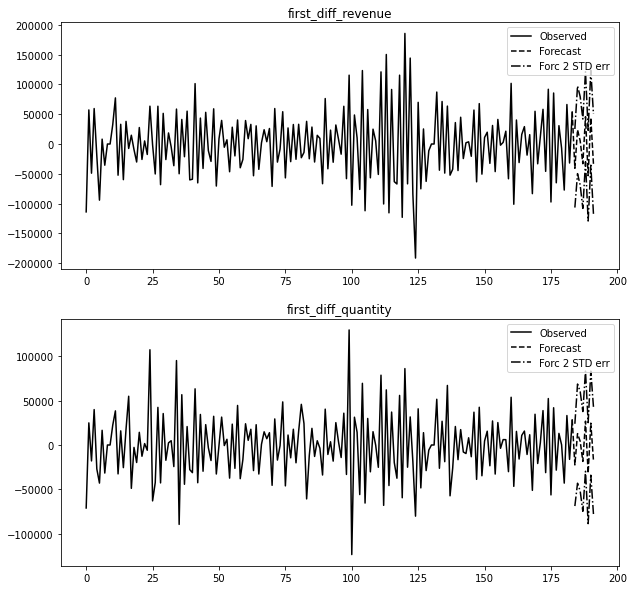

In [117]:
ts_model.plot_forecast(8);

In [102]:
ts_model.forecast(test.values, len(test))[:,0]

array([424777.84826068, 312491.51238758, 249662.29858656, 251908.17059706,
       245992.35264695, 234103.52217901, 216479.65612499, 204694.64474328,
       197480.16521724, 195361.68514668, 192115.64112085, 187912.89268498,
       184352.73877737, 182819.1931055 , 181756.65502759, 180587.75252788,
       179447.63571255, 178709.71769199, 178189.92994081, 177785.17281247,
       177441.36808126, 177173.17427993, 176955.63404757, 176794.58689038,
       176674.91229031, 176581.13849921, 176501.66792208])

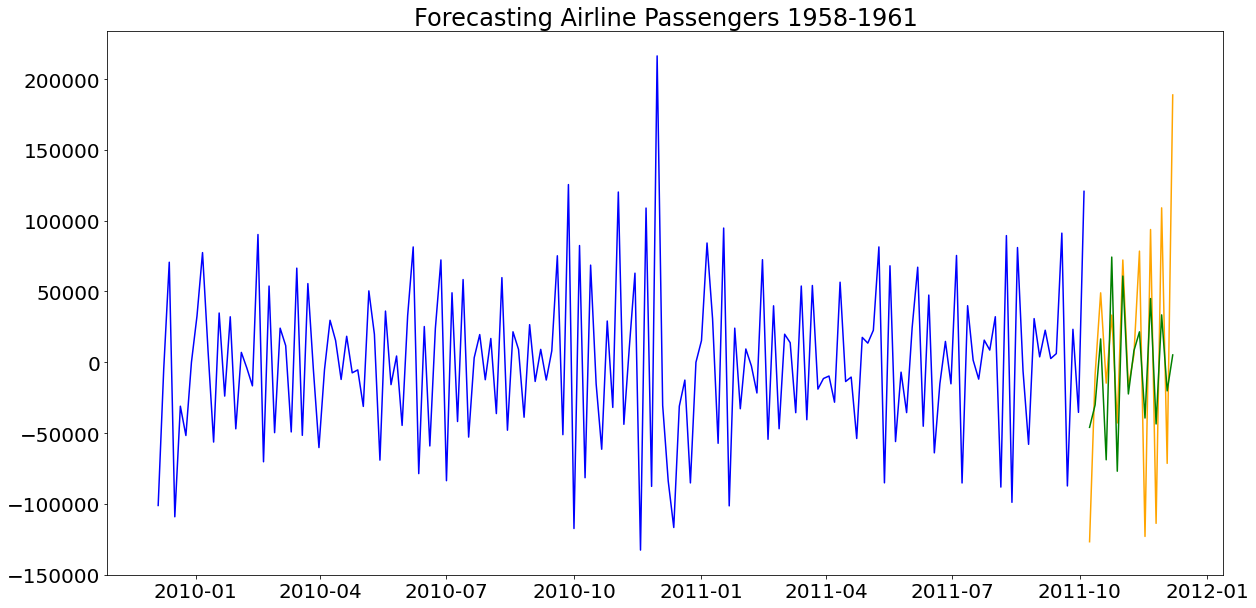

In [185]:
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values[:,0], color = 'blue')

# Plot testing data.
plt.plot(test.index, test.values[:,0], color = 'orange')

# Plot predicted test values.
plt.plot(test.index, ts_model.forecast(test.values, len(test))[:,0], color = 'green')

# Set label.
plt.title(label = 'Forecasting Airline Passengers 1958-1961', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

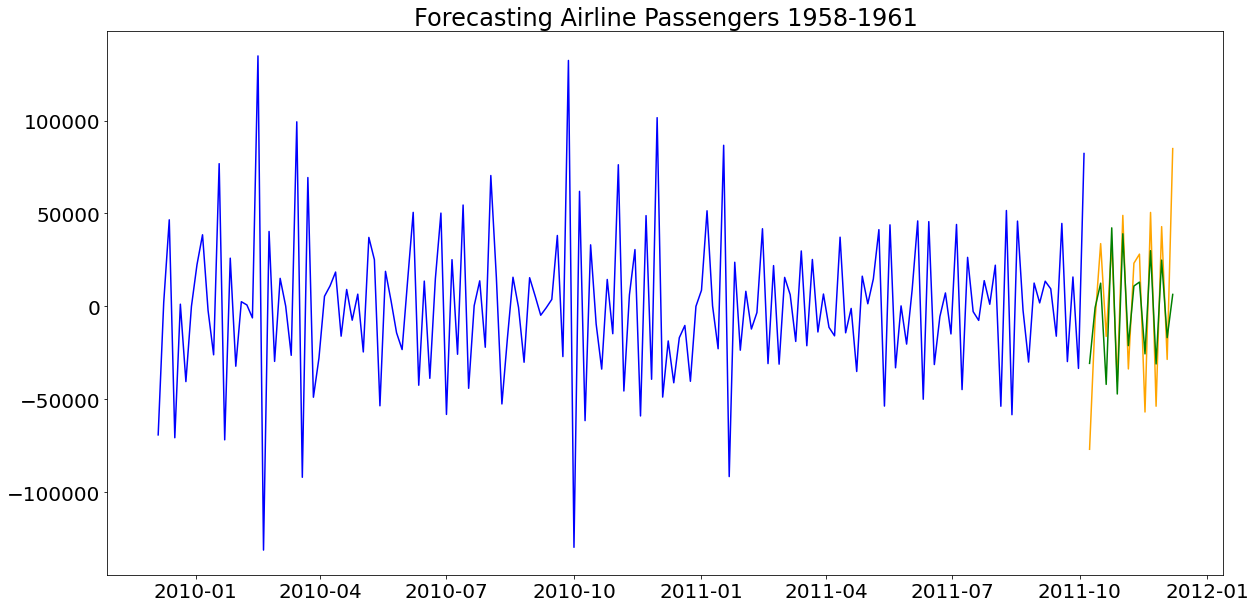

In [186]:
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values[:,1], color = 'blue')

# Plot testing data.
plt.plot(test.index, test.values[:,1], color = 'orange')

# Plot predicted test values.
plt.plot(test.index, ts_model.forecast(test.values, len(test))[:,1], color = 'green')

# Set label.
plt.title(label = 'Forecasting Airline Passengers 1958-1961', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [182]:
# Let's use MSE to evaluate our models.

# Save our forecast as forecast.
forecast = ts_model.forecast(train.values, len(test))

# Instantiate MSE values at 0.
mse_quant = 0
mse_rev = 0

# Loop through each forecasted time point.
for time in range(len(test)):
    
    # Calculate (expected - observed) ** 2 and add to MSE.
    mse_quant += (forecast[time][0] - test.values[time][0]) ** 2
    mse_rev += (forecast[time][1] - test.values[time][1]) ** 2

# Divide SSE to get MSE.
mse_quant /= len(test)
mse_rev /= len(test)
    
# Generate output.    
print(f'The test MSE on the Quantity data is: {round(mse_quant, 4)}')
print(f'The test MSE on the Revenue data is: {round(mse_rev, 4)}')


The test MSE on the Quantity data is: 4365397189.5312
The test MSE on the Revenue data is: 899916696.2048


In [216]:

fig = go.Figure([
    go.Scatter(
        name='Actual',
        x=train.index,
        y=train.values[:,1],
        mode='markers+lines',
        marker=dict(color='darkblue', size=1),
        line=dict(width=1),       
        showlegend=True
    ),
    go.Scatter(
        name='Actual',
        x=test.index,
        y=test.values[:,1],
        mode='markers+lines',
        marker=dict(color='darkblue', size=1),
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='Forcasted',
        x=test.index,
        y=ts_model.forecast(test.values, len(test))[:,1],
        mode='lines',
        marker=dict(color="red", size = 2),
        line=dict(width=1),
        showlegend=True
    )
])
fig.update_xaxes(rangeslider_visible=True)

fig.show()